# Gesture Recognition
In this group project, you are going to build a 3D Conv model that will be able to predict the 5 gestures correctly. Please import the following libraries to get started.

## Environment Setup

In [1]:
!pip install -q ipython-autotime

%load_ext autotime

     |████████████████████████████████| 1.6 MB 38.9 MB/s 
time: 398 µs (started: 2022-12-03 08:24:50 +00:00)


In [2]:
# Checking the GPU configuration

!nvidia-smi

Sat Dec  3 08:24:51 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  A100-SXM4-40GB      Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    51W / 350W |      0MiB / 40536MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
import abc
import cv2
import numpy as np
import os
import warnings
from datetime import datetime
from zipfile import ZipFile

from imageio import imread
from math import ceil
from matplotlib import pyplot as plt
from PIL import Image, ImageFilter, ImageEnhance
from skimage.transform import resize as imresize

%matplotlib inline
warnings.filterwarnings("ignore")

time: 1.35 s (started: 2022-12-03 08:24:51 +00:00)


We set the random seed so that the results don't vary drastically.

In [4]:
np.random.seed(30)
import random as rn
rn.seed(30)
from keras import backend as K
import tensorflow as tf

tf.random.set_seed(30)

time: 2.26 s (started: 2022-12-03 08:24:52 +00:00)


In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

In [5]:
# Setting Folder Structure to Save Model Files
from google.colab import drive

SAVE_TO_DRIVE = True

date_time = datetime.now().strftime("%d_%m_%Y_%H_%M_%S")

if SAVE_TO_DRIVE:
    drive.mount("/content/gdrive")
    BASE_PATH = f"/content/gdrive/My Drive/UpGradProjects/GestureRecognition/Experiments_{date_time}"
else:
    BASE_PATH = f"{os.getcwd()}/Experiments_{date_time}"

if not os.path.exists(BASE_PATH):
    os.makedirs(BASE_PATH)

Mounted at /content/gdrive
time: 27.8 s (started: 2022-12-03 08:24:55 +00:00)


## Download the Dataset

#### Helper Functions

In [6]:
def run_cmd(cmd, verbose=False, *args, **kwargs) -> None:
    """
    Run system command as a subprocess
    """
    import subprocess

    process = subprocess.Popen(cmd,
                               stdout=subprocess.PIPE,
                               stderr=subprocess.PIPE,
                               text=True,
                               shell=True)
    std_out, std_err = process.communicate()
    if verbose:
        print(std_out.strip(), std_err)

time: 975 µs (started: 2022-12-03 08:25:23 +00:00)


In [7]:
import os, requests
from math import ceil
from tqdm import tqdm

def download_file_google_drive(id: str, f_name: str, f_save_path: str=""):
    """
    Download file from Google Drive

    Args:
        id (str): Google Drive File ID
        f_name (str): File name
        f_save_path (str): File save path. 
            default: Current working directory
    """
    def get_confirm_token(response):
        for key, value in response.cookies.items():
            if key.startswith('download_warning'):
                return value
        return None

    def save_response_content(response, destination):
        CHUNK_SIZE = 32768
        with open(destination, "wb") as f:
            TOTAL_FILE_SIZE_BYTES = int(response.headers.get('content-length', 0))
            with tqdm(total=TOTAL_FILE_SIZE_BYTES, unit='iB', unit_scale=True) as pbar:
                for chunk in response.iter_content(CHUNK_SIZE):
                    pbar.update(len(chunk))
                    if chunk: # filter out keep-alive new chunks
                        f.write(chunk)

    URL = "https://drive.google.com/uc?export=download&confirm=yTib"

    f_save_path = os.getcwd() if not f_save_path else f_save_path.rstrip("/")
    destination = f"{f_save_path}/{f_name}"

    session = requests.Session()
    response = session.get(URL, params = { 'id' : id }, stream = True)
    token = get_confirm_token(response)

    if token:
        params = { 'id' : id, 'confirm' : token }
        response = session.get(URL, params = params, stream = True)
    
    save_response_content(response, destination)

time: 2.58 ms (started: 2022-12-03 08:25:23 +00:00)


In [8]:
def extract_data(zip_file_name):
    with ZipFile(zip_file_name, "r") as zip_ref:
     for file in tqdm(iterable=zip_ref.namelist(), total=len(zip_ref.namelist()), unit='iB', unit_scale=True):
          zip_ref.extract(member=file)

time: 717 µs (started: 2022-12-03 08:25:23 +00:00)


#### Downloading and Extracing Dataset

In [9]:
dataset_zip_file_id = "1ehyrYBQ5rbQQe6yL4XbLWe3FMvuVUGiL"
dataset_zip_file_name = "Project_data.zip"

print("Downloading Project Dataset")
download_file_google_drive(id=dataset_zip_file_id, f_name=dataset_zip_file_name)

print("Extracting Project Dataset")
extract_data(dataset_zip_file_name)

os.remove(dataset_zip_file_name)

project_dataset_path = f"{os.getcwd()}/{dataset_zip_file_name[:-4]}"

100%|██████████| 1.71G/1.71G [00:07<00:00, 228MiB/s]


Extracting Project Dataset


100%|██████████| 23.7k/23.7k [00:13<00:00, 1.73kiB/s]


time: 23.5 s (started: 2022-12-03 08:25:23 +00:00)


In [10]:
train_doc = np.random.permutation(open(f"{project_dataset_path}/train.csv").readlines())
val_doc = np.random.permutation(open(f"{project_dataset_path}/val.csv").readlines())
batch_size = 32 #experiment with the batch size

# Data augmentation
enable_augmentation = False 
# Sequence IDs - selecting alternate frames from 7 to 26.
seq_idx = range(7, 26, 2)
# Image Dimensions
dim_x, dim_y = 120, 120

time: 2.75 ms (started: 2022-12-03 08:25:46 +00:00)


## Image Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

In [11]:
class ImageGenerator:
    def __init__(self, image_height, image_width, channels, total_frames, 
                 num_classes, frames_to_sample, batch_size, normalize=True):
        self.image_height = image_height
        self.image_width = image_width
        self.channels = channels
        self.num_classes = num_classes
        self.total_frames = total_frames
        self.frames_to_sample = frames_to_sample
        self.batch_size = batch_size
        self.normalize = normalize

    def generator(self, source_path, folder_list, augmention=False):
        """
        Image Generator.
        """
        img_idx = np.round(np.linspace(0,
                                       self.total_frames - 1,
                                       self.frames_to_sample)).astype(int)
        while True:
            t = np.random.permutation(folder_list)
            num_batches = len(t) // self.batch_size
        
            for batch in range(num_batches): 
                batch_data, batch_labels = self._generate_single_batch(source_path, 
                                                                       t,
                                                                       batch,
                                                                       self.batch_size,
                                                                       img_idx,
                                                                       augmention)
                yield batch_data, batch_labels 

            remaining_seq = len(t) % self.batch_size
        
            if (remaining_seq != 0):
                batch_data, batch_labels = self._generate_single_batch(source_path, 
                                                                       t,
                                                                       num_batches,
                                                                       self.batch_size,
                                                                       img_idx,
                                                                       augmention,
                                                                       remaining_seq)
                yield batch_data, batch_labels 
    
    def _generate_single_batch(self, source_path, t, batch, batch_size, img_idx, augmention, remaining_seq=0):
        """
        Generate a single batch data.
        """
        seq_len = remaining_seq if remaining_seq else batch_size
    
        batch_data = np.zeros((seq_len, len(img_idx), 
                               self.image_height, 
                               self.image_width, 
                               self.channels)) 
        batch_labels = np.zeros((seq_len, self.num_classes)) 
    
        if (augmention): 
            batch_data_aug = np.zeros((seq_len, 
                                       len(img_idx), 
                                       self.image_height, 
                                       self.image_width, 
                                       self.channels))
        
        for folder in range(seq_len): 
            imgs = os.listdir(f"{source_path}/{t[folder + (batch * batch_size)].split(';')[0]}") 
            for idx,item in enumerate(img_idx):
                # performing image reading and resizing
                image_path = f"{source_path}/{t[folder + (batch * batch_size)].strip().split(';')[0]}/{imgs[item]}"
                image = imread(image_path).astype(np.float32)
                image_resized=imresize(image, (self.image_height, self.image_width, 3))

                # normalizing the images
                if self.normalize:
                    batch_data[folder,idx,:,:,0] = (image_resized[:,:,0]) / 255
                    batch_data[folder,idx,:,:,1] = (image_resized[:,:,1]) / 255
                    batch_data[folder,idx,:,:,2] = (image_resized[:,:,2]) / 255
                else:
                    batch_data[folder,idx,:,:,0] = (image_resized[:,:,0])
                    batch_data[folder,idx,:,:,1] = (image_resized[:,:,1])
                    batch_data[folder,idx,:,:,2] = (image_resized[:,:,2])
            
                if (augmention):
                    shifted = cv2.warpAffine(image, 
                                             np.float32([[1, 0, np.random.randint(-30,30)], 
                                                         [0, 1, np.random.randint(-30,30)]]), 
                                             (image.shape[1], image.shape[0]))
                    
                    gray = cv2.cvtColor(shifted, cv2.COLOR_BGR2GRAY)

                    x0, y0 = np.argwhere(gray > 0).min(axis=0)
                    x1, y1 = np.argwhere(gray > 0).max(axis=0) 
                    # cropping the images to have the targeted gestures and remove the noise from the images.
                    cropped=shifted[x0:x1,y0:y1,:]
                    
                    image_resized = imresize(cropped, 
                                             (self.image_height, self.image_width, 3))
            
                    if self.normalize:
                        batch_data_aug[folder, idx, :, :, 0] = (image_resized[:, :, 0]) / 255
                        batch_data_aug[folder, idx, :, :, 1] = (image_resized[:, :, 1]) / 255
                        batch_data_aug[folder, idx, :, :, 2] = (image_resized[:, :, 2]) / 255
                    else:
                        batch_data_aug[folder, idx, :, :, 0] = (image_resized[:, :, 0])
                        batch_data_aug[folder, idx, :, :, 1] = (image_resized[:, :, 1])
                        batch_data_aug[folder, idx, :, :, 2] = (image_resized[:, :, 2])
                
            
            batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
    
        if (augmention):
            batch_data=np.concatenate([batch_data, batch_data_aug])
            batch_labels=np.concatenate([batch_labels, batch_labels])
        
        return(batch_data, batch_labels)

time: 6.87 ms (started: 2022-12-03 08:25:46 +00:00)


Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

## Model Experimentations
Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

#### Importing Necessary Modules

In [12]:
from keras.optimizers import Adam, SGD
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras.layers import (Activation, 
                          BatchNormalization,
                          Dense, 
                          Dropout, 
                          Flatten,
                          GlobalAveragePooling3D, 
                          GRU,
                          LSTM, 
                          TimeDistributed)
from keras.layers.convolutional import Conv2D, Conv3D, MaxPooling2D, MaxPooling3D
from keras.models import Sequential, Model


time: 824 µs (started: 2022-12-03 08:25:46 +00:00)


### BaseModel Class

We will be following a `BaseModel -> Model` class structure to make easier experimentation and code-reusability.

In [13]:
class BaseModel(metaclass=abc.ABCMeta):
    """
    Base Model implementation to initialize, define, compile, train, save and 
    plot models over different experiments.
    """
    def initialize_path(self, project_folder):
        """
        Initialize the path where project data resides
        """
        self.train_path = f"{project_folder}/train"
        self.validation_path = f"{project_folder}/val"
        self.train_doc = np.random.permutation(open(f"{project_folder}/train.csv").readlines())
        self.validation_doc = np.random.permutation(open(f"{project_folder}/val.csv").readlines())
        self.num_train_sequences = len(self.train_doc)
        self.num_val_sequences = len(self.validation_doc)
        print(f"Training Path => {self.train_path}")
        print(f"Number of Training Sequence = {self.num_train_sequences}")
        print(f"Validation Path => {self.validation_path}")
        print(f"Number of Validation Sequence = {self.num_val_sequences}")
       
    def initialize_image_properties(self, image_height=100, image_width=100):
        """
        Initialize the image/frame properties
        """
        self.image_height=image_height
        self.image_width=image_width
        self.channels=3
        self.num_classes=5
        self.total_frames=30
        print(f"Height = {self.image_height}; Width = {self.image_width}; Channels = {self.channels}")
        print(f"Number of Classes = {self.num_classes}; Total Franes = {self.total_frames}")
    
    def initialize_hyperparams(self, frames_to_sample=30, batch_size=32, num_epochs=50):
        """
        Initialize hyperparameters (batch size, frames to sample and the number 
        of epochs) for the model. 
        """
        self.frames_to_sample=frames_to_sample
        self.batch_size=batch_size
        self.num_epochs=num_epochs
        print(f"Frames to Sample = {self.frames_to_sample}; Batch Size = {self.batch_size}; Number of Epochs = {self.num_epochs}")

    def train_validation_generator(self, normalize=True, enable_augmentation=True):
        """
        Create the `train_generator` and the `val_generator` which will be used 
        in the `fit_generator()` method.
        """
        image_generator = ImageGenerator(self.image_height, 
                                         self.image_width, 
                                         self.channels, 
                                         self.total_frames, 
                                         self.num_classes, 
                                         self.frames_to_sample, 
                                         self.batch_size,
                                         normalize=normalize)
        
        self.train_generator = image_generator.generator(self.train_path, 
                                                         self.train_doc,  
                                                         augmention=enable_augmentation)

        self.validation_generator = image_generator.generator(self.validation_path, 
                                                              self.validation_doc)

    # Define the model
    @abc.abstractmethod
    def define_model(self):
        """
        Define the model for the experiment. This method needs to be defined by 
        individual experiment class objects.
        """
        pass

    def print_model_summary(self):
        """
        Print the model summary.
        """
        print(f"Model Name: {self.model_name}")
        print(self.model.summary())

    def compile_model(self, optimiser=Adam()):
        """
        Compile the model.
        """ 
        self.model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        
    def initialize_callbacks(self, save_best_only=True, save_weights_only=True):
        """
        Initialize callbacks.
        """
        if not os.path.exists(f"{BASE_PATH}/{self.model_name}"):
            os.mkdir(f"{BASE_PATH}/{self.model_name}")
                
        filepath = BASE_PATH + "/" + self.model_name + "/model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5"
        # filepath = self.model_name + "/model-{epoch:05d}.h5"

        model_checkpoint = ModelCheckpoint(filepath,
                                           monitor='val_loss', 
                                           verbose=0,
                                           save_best_only=save_best_only, 
                                           save_weights_only=save_weights_only, 
                                           mode='auto', 
                                           save_freq='epoch')

        reduce_LR_on_plateau = ReduceLROnPlateau(monitor='val_loss', 
                                                factor=0.2, 
                                                patience=5, 
                                                verbose=1)

        self.callbacks_list = [model_checkpoint, reduce_LR_on_plateau]

    def fit_model(self):
        """
        Fir the model. The `steps_per_epoch` and `validation_steps` are used by 
        `fit_generator` to decide the number of next() calls it need to make.
        """
        train_steps_per_epoch = ceil(self.num_train_sequences/self.batch_size)

        validation_steps_per_epoch = ceil(self.num_val_sequences/self.batch_size)

        self.history = self.model.fit_generator(self.train_generator, 
                                                steps_per_epoch=train_steps_per_epoch, 
                                                epochs=self.num_epochs,
                                                verbose=1, 
                                                callbacks=self.callbacks_list,
                                                validation_data=self.validation_generator, 
                                                validation_steps=validation_steps_per_epoch, 
                                                class_weight=None, 
                                                workers=1,
                                                initial_epoch=0)
    
    def save_model_and_history(self):
        """
        Save model and history.
        """
        model_file = f"{BASE_PATH}/{self.model_name}/{self.model_name}.h5"
        history_file = f"{BASE_PATH}/{self.model_name}/{self.model_name}_history.npy"
        print(f"Saving Model at {model_file} and History at {history_file}")
        self.model.save(model_file)
        np.save(history_file, self.history)
        
    def plot_model_loss_and_accuracy(self):
        """
        Plot the model loss and accuracy.
        """
        fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 6))
        validation_loss = min(self.history.history["val_loss"])
        validation_accuracy = max(self.history.history["val_categorical_accuracy"])
        fig.suptitle(f"{self.model_name}\n Validation Loss = {validation_loss:.4f} and Validation Accuracy = {validation_accuracy:.4f}", 
                     fontsize=14)

        axes[0].plot(self.history.history['loss'])   
        axes[0].plot(self.history.history['val_loss'])
        axes[0].set_title('Model - Loss')
        axes[0].set_xlabel('Epoch')
        axes[0].set_ylabel('Loss')
        axes[0].legend(['Train', 'Validation'], loc='best')

        axes[1].plot(self.history.history['categorical_accuracy'])   
        axes[1].plot(self.history.history['val_categorical_accuracy'])
        axes[1].set_title('Model - Categorical Accuracy')
        axes[1].set_xlabel('Loss')
        axes[1].set_ylabel('Categorical Accuracy')
        axes[1].legend(['Train', 'Validation'], loc='best')

        fig.savefig(f"{BASE_PATH}/{self.model_name}.png")

time: 22.6 ms (started: 2022-12-03 08:25:46 +00:00)


### Experiment - 1

#### Conv3D

* `filtersize` = (3, 3, 3)
* `dense_neurons` = 64
* `dropout` = 0.5
* `frames_to_sample` = 25 
* `batch_size` = 34
* `num_epochs` = 5
* `enable_augmentation` = False


In [14]:
class Experiment1Conv3D(BaseModel):
    def define_model(self):
        filtersize = (3, 3, 3)
        dense_neurons = 64
        dropout = 0.5

        self.exp_name = "Experiment1_Conv3D"
        date_time = datetime.now().strftime("%d_%m_%Y_%H_%M_%S")
        self.model_name = f"model_{self.exp_name}_{date_time}"
        
        self.model = Sequential()
        
        self.model.add(Conv3D(16, filtersize, 
                              padding="same",
                              activation='relu',
                              input_shape=(self.frames_to_sample,
                                           self.image_height,
                                           self.image_width,
                                           self.channels)))
        self.model.add(BatchNormalization())
        self.model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        self.model.add(Conv3D(32, filtersize, activation='relu'))
        self.model.add(BatchNormalization())
        self.model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        self.model.add(Conv3D(64, filtersize, padding="same", activation='relu'))
        self.model.add(BatchNormalization())
        self.model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        self.model.add(Conv3D(128, filtersize, padding="same", activation='relu'))
        self.model.add(BatchNormalization())
        self.model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        self.model.add(Flatten())
        self.model.add(Dense(dense_neurons, activation='relu'))
        self.model.add(BatchNormalization())
        self.model.add(Dropout(dropout))

        self.model.add(Dense(dense_neurons, activation='relu'))
        self.model.add(BatchNormalization())
        self.model.add(Dropout(dropout))

        self.model.add(Dense(self.num_classes, activation='softmax'))


time: 2.83 ms (started: 2022-12-03 08:25:46 +00:00)


Training Path => /content/Project_data/train
Number of Training Sequence = 663
Validation Path => /content/Project_data/val
Number of Validation Sequence = 100
Height = 120; Width = 120; Channels = 3
Number of Classes = 5; Total Franes = 30
Frames to Sample = 25; Batch Size = 34; Number of Epochs = 5
Model Name: model_Experiment1_Conv3D_03_12_2022_08_25_46
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 25, 120, 120, 16)  1312      
                                                                 
 batch_normalization (BatchN  (None, 25, 120, 120, 16)  64       
 ormalization)                                                   
                                                                 
 max_pooling3d (MaxPooling3D  (None, 12, 60, 60, 16)   0         
 )                                                               
                           

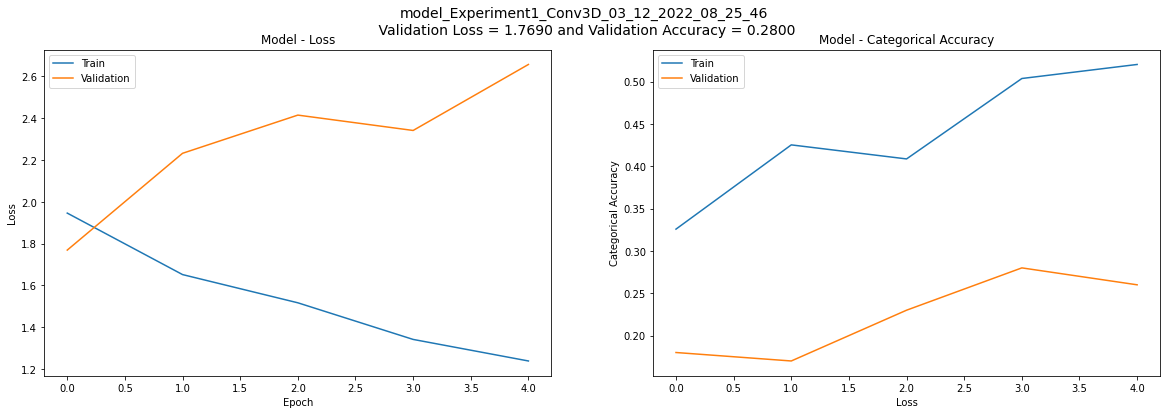

time: 10min 53s (started: 2022-12-03 08:25:46 +00:00)


In [15]:
# Exeperiment 1 - Conv3D
experiment1_conv3d = Experiment1Conv3D()

# Initialize the path where project data resides
experiment1_conv3d.initialize_path(project_dataset_path)

# Initialize the image properties
experiment1_conv3d.initialize_image_properties(image_height=dim_x, 
                                               image_width=dim_y)

# Initialize the batch size, frames to sample and the no. of epochs
experiment1_conv3d.initialize_hyperparams(frames_to_sample=25, 
                                          batch_size=34,
                                          num_epochs=5)

# Define the model
experiment1_conv3d.define_model()

# Print the model summary
experiment1_conv3d.print_model_summary()

# Compile the model
experiment1_conv3d.compile_model()

# Train and validation generator
experiment1_conv3d.train_validation_generator(enable_augmentation=False)

# Initialize callbacks
experiment1_conv3d.initialize_callbacks()

# Fit the model
experiment1_conv3d.fit_model()

# Save model and history
experiment1_conv3d.save_model_and_history()

# Plot model loss and accuracy
experiment1_conv3d.plot_model_loss_and_accuracy()


### Experiment - 2

#### Conv3D

Adding additional layers to the model.

* `filtersize` = (3, 3, 3)
* `dense_neurons` = 256
* `dropout` = 0.5
* `frames_to_sample` = 20 
* `batch_size` = 26
* `num_epochs` = 25
* `enable_augmentation` = False


In [16]:
class Experiment2Conv3D(BaseModel):
    def define_model(self):
        filtersize = (3, 3, 3)
        dense_neurons = 256
        dropout = 0.5

        self.exp_name = "Experiment2_Conv3D"
        date_time = datetime.now().strftime("%d_%m_%Y_%H_%M_%S")
        self.model_name = f"model_{self.exp_name}_{date_time}"
        
        self.model = Sequential()
        
        self.model.add(Conv3D(16, filtersize, 
                              padding="same", 
                              input_shape=(self.frames_to_sample,
                                           self.image_height,
                                           self.image_width,
                                           self.channels)))
        self.model.add(Activation('relu'))
        self.model.add(BatchNormalization())
        
        self.model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        self.model.add(Conv3D(32, filtersize, padding="same"))
        self.model.add(Activation('relu'))
        self.model.add(BatchNormalization())
        
        self.model.add(Conv3D(32, filtersize, padding="same"))
        self.model.add(Activation('relu'))
        self.model.add(BatchNormalization())

        self.model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        self.model.add(Conv3D(64, filtersize, padding="same"))
        self.model.add(Activation('relu'))
        self.model.add(BatchNormalization())
        
        self.model.add(Conv3D(64, filtersize, padding="same"))
        self.model.add(Activation('relu'))
        self.model.add(BatchNormalization())
        
        self.model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        self.model.add(Conv3D(128, filtersize, padding="same"))
        self.model.add(Activation('relu'))
        self.model.add(BatchNormalization())
        
        self.model.add(Conv3D(128, filtersize, padding="same"))
        self.model.add(Activation('relu'))
        self.model.add(BatchNormalization())

        self.model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        
        self.model.add(Flatten())
        self.model.add(Dense(dense_neurons, activation='relu'))
        self.model.add(Dropout(dropout))
        self.model.add(BatchNormalization())

        self.model.add(Dense(dense_neurons, activation='relu'))
        self.model.add(BatchNormalization())
        self.model.add(Dropout(dropout))

        self.model.add(Dense(self.num_classes, activation='softmax'))


time: 4.53 ms (started: 2022-12-03 08:36:40 +00:00)


Training Path => /content/Project_data/train
Number of Training Sequence = 663
Validation Path => /content/Project_data/val
Number of Validation Sequence = 100
Height = 120; Width = 120; Channels = 3
Number of Classes = 5; Total Franes = 30
Frames to Sample = 20; Batch Size = 26; Number of Epochs = 25
Model Name: model_Experiment2_Conv3D_03_12_2022_08_36_40
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_4 (Conv3D)           (None, 20, 120, 120, 16)  1312      
                                                                 
 activation (Activation)     (None, 20, 120, 120, 16)  0         
                                                                 
 batch_normalization_6 (Batc  (None, 20, 120, 120, 16)  64       
 hNormalization)                                                 
                                                                 
 max_pooling3d_4 (MaxPoo

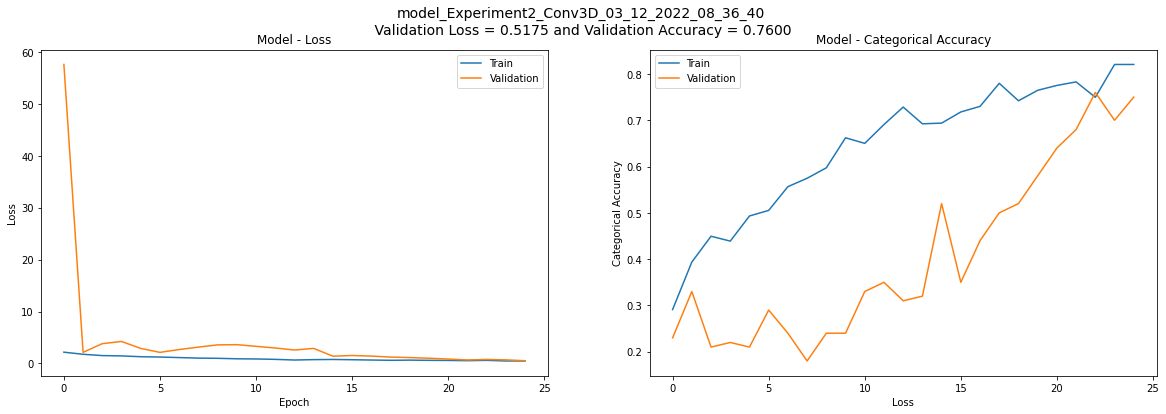

time: 41min 49s (started: 2022-12-03 08:36:40 +00:00)


In [17]:
# Exeperiment 2 - Conv3D
experiment2_conv3d = Experiment2Conv3D()

# Initialize the path where project data resides
experiment2_conv3d.initialize_path(project_dataset_path)

# Initialize the image properties
experiment2_conv3d.initialize_image_properties(image_height=dim_x, 
                                               image_width=dim_y)

# Initialize the batch size, frames to sample and the no. of epochs
experiment2_conv3d.initialize_hyperparams(frames_to_sample=20, 
                                          batch_size=26,
                                          num_epochs=25)

# Define the model
experiment2_conv3d.define_model()

# Print the model summary
experiment2_conv3d.print_model_summary()

# Compile the model
experiment2_conv3d.compile_model()

# Train and validation generator
experiment2_conv3d.train_validation_generator(enable_augmentation=False)

# Initialize callbacks
experiment2_conv3d.initialize_callbacks()

# Fit the model
experiment2_conv3d.fit_model()

# Save model and history
experiment2_conv3d.save_model_and_history()

# Plot model loss and accuracy
experiment2_conv3d.plot_model_loss_and_accuracy()


### Experiment - 3

#### Conv3D

The model is overfitting. Reducing the number of parameters.

* `dense_neurons` = 64
* `dropout` = 0.3
* `frames_to_sample` = 20 
* `batch_size` = 13
* `num_epochs` = 25
* `enable_augmentation` = False

In [18]:
class Experiment3Conv3D(BaseModel):
    def define_model(self):
        dense_neurons = 64
        dropout = 0.3

        self.exp_name = "Experiment3_Conv3D"
        date_time = datetime.now().strftime("%d_%m_%Y_%H_%M_%S")
        self.model_name = f"model_{self.exp_name}_{date_time}"
        
        self.model = Sequential()
        self.model.add(Conv3D(16, (3, 3, 3), 
                              padding="same",
                              input_shape=(self.frames_to_sample,
                                           self.image_height,
                                           self.image_width,
                                           self.channels)))
        self.model.add(Activation('relu'))
        self.model.add(BatchNormalization())
        self.model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        self.model.add(Conv3D(32, (3, 3, 3), padding="same"))
        self.model.add(Activation('relu'))
        self.model.add(BatchNormalization())
        self.model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        self.model.add(Conv3D(64, (2, 2, 2), padding="same"))
        self.model.add(Activation('relu'))
        self.model.add(BatchNormalization())
        self.model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        self.model.add(Conv3D(128, (2, 2, 2), padding="same"))
        self.model.add(Activation('relu'))
        self.model.add(BatchNormalization())
        self.model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        
        self.model.add(Flatten())
        self.model.add(Dense(dense_neurons, activation='relu'))
        self.model.add(BatchNormalization())
        self.model.add(Dropout(dropout))

        self.model.add(Dense(dense_neurons, activation='relu'))
        self.model.add(BatchNormalization())
        self.model.add(Dropout(dropout))

        self.model.add(Dense(self.num_classes, activation='softmax'))


time: 3.9 ms (started: 2022-12-03 09:18:29 +00:00)


Training Path => /content/Project_data/train
Number of Training Sequence = 663
Validation Path => /content/Project_data/val
Number of Validation Sequence = 100
Height = 120; Width = 120; Channels = 3
Number of Classes = 5; Total Franes = 30
Frames to Sample = 20; Batch Size = 13; Number of Epochs = 25
Model Name: model_Experiment3_Conv3D_03_12_2022_09_18_29
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_11 (Conv3D)          (None, 20, 120, 120, 16)  1312      
                                                                 
 activation_7 (Activation)   (None, 20, 120, 120, 16)  0         
                                                                 
 batch_normalization_15 (Bat  (None, 20, 120, 120, 16)  64       
 chNormalization)                                                
                                                                 
 max_pooling3d_8 (MaxPoo

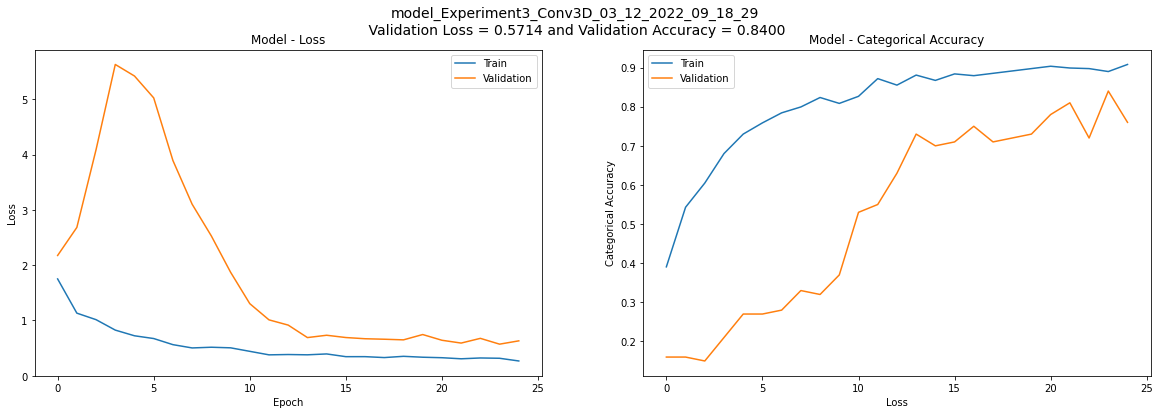

time: 41min 23s (started: 2022-12-03 09:18:29 +00:00)


In [19]:
# Exeperiment 3 - Conv3D
experiment3_conv3d = Experiment3Conv3D()

# Initialize the path where project data resides
experiment3_conv3d.initialize_path(project_dataset_path)

# Initialize the image properties
experiment3_conv3d.initialize_image_properties(image_height=dim_x, 
                                               image_width=dim_y)

# Initialize the batch size, frames to sample and the no. of epochs
experiment3_conv3d.initialize_hyperparams(frames_to_sample=20, 
                                          batch_size=13,
                                          num_epochs=25)

# Define the model
experiment3_conv3d.define_model()

# Print the model summary
experiment3_conv3d.print_model_summary()

# Compile the model
experiment3_conv3d.compile_model()

# Train and validation generator
experiment3_conv3d.train_validation_generator(enable_augmentation=False)

# Initialize callbacks
experiment3_conv3d.initialize_callbacks()

# Fit the model
experiment3_conv3d.fit_model()

# Save model and history
experiment3_conv3d.save_model_and_history()

# Plot model loss and accuracy
experiment3_conv3d.plot_model_loss_and_accuracy()


### Experiment - 4

#### Conv3D

Modifying the number of hyperparameters again.

* `dense_neurons` = 256
* `dropout` = 0.5
* `frames_to_sample` = 20 
* `batch_size` = 13
* `num_epochs` = 50
* `enable_augmentation` = False

In [20]:
class Experiment4Conv3D(BaseModel):
    def define_model(self):
        dense_neurons = 128
        dropout = 0.5

        self.exp_name = "Experiment4_Conv3D"
        date_time = datetime.now().strftime("%d_%m_%Y_%H_%M_%S")
        self.model_name = f"model_{self.exp_name}_{date_time}"
        
        self.model = Sequential()
        self.model.add(Conv3D(32, 
                              kernel_size=3, 
                              padding="same", 
                              activation='relu',
                              input_shape=(self.frames_to_sample,
                                           self.image_height,
                                           self.image_width,
                                           self.channels)))
        self.model.add(Conv3D(64, kernel_size=3, padding="same", activation='relu'))
        self.model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        self.model.add(BatchNormalization())
        self.model.add(Dropout(dropout))

        self.model.add(Conv3D(128, kernel_size=3, padding="same", activation='relu'))
        self.model.add(MaxPooling3D(pool_size=(1, 2, 2)))
        self.model.add(BatchNormalization())
        self.model.add(Dropout(dropout))

        self.model.add(Conv3D(256, kernel_size=(1, 3, 3), activation='relu'))
        self.model.add(MaxPooling3D(pool_size=(1, 2, 2)))
        self.model.add(BatchNormalization())
        self.model.add(Dropout(dropout))
        
        self.model.add(Flatten())
        self.model.add(Dense(dense_neurons, activation='relu'))
        self.model.add(BatchNormalization())
        self.model.add(Dropout(dropout))

        self.model.add(Dense(self.num_classes, activation='softmax'))


time: 3.63 ms (started: 2022-12-03 09:59:53 +00:00)


Training Path => /content/Project_data/train
Number of Training Sequence = 663
Validation Path => /content/Project_data/val
Number of Validation Sequence = 100
Height = 120; Width = 120; Channels = 3
Number of Classes = 5; Total Franes = 30
Frames to Sample = 20; Batch Size = 13; Number of Epochs = 50
Model Name: model_Experiment4_Conv3D_03_12_2022_09_59_53
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_15 (Conv3D)          (None, 20, 120, 120, 32)  2624      
                                                                 
 conv3d_16 (Conv3D)          (None, 20, 120, 120, 64)  55360     
                                                                 
 max_pooling3d_12 (MaxPoolin  (None, 10, 60, 60, 64)   0         
 g3D)                                                            
                                                                 
 batch_normalization_21 

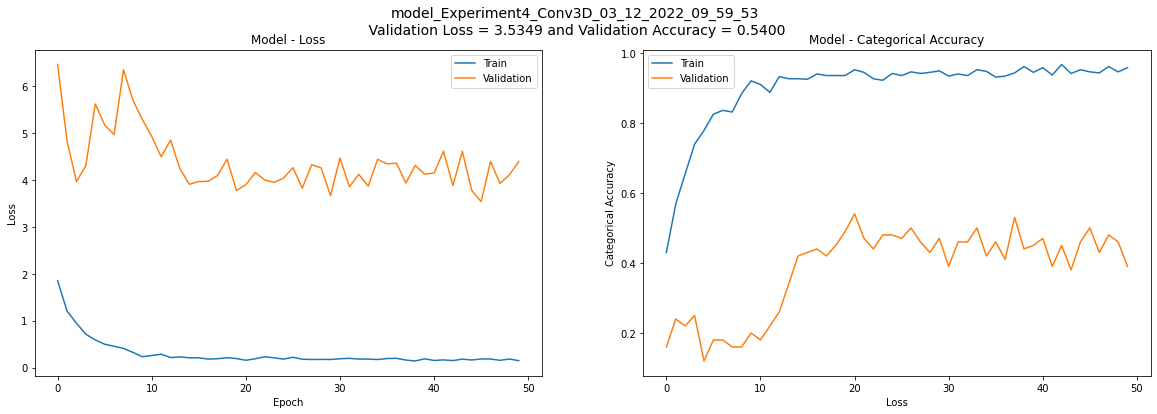

time: 1h 22min 31s (started: 2022-12-03 09:59:53 +00:00)


In [21]:
# Exeperiment 4 - Conv3D
experiment4_conv3d = Experiment4Conv3D()

# Initialize the path where project data resides
experiment4_conv3d.initialize_path(project_dataset_path)

# Initialize the image properties
experiment4_conv3d.initialize_image_properties(image_height=dim_x, 
                                               image_width=dim_y)

# Initialize the batch size, frames to sample and the no. of epochs
experiment4_conv3d.initialize_hyperparams(frames_to_sample=20, 
                                          batch_size=13,
                                          num_epochs=50)

# Define the model
experiment4_conv3d.define_model()

# Print the model summary
experiment4_conv3d.print_model_summary()

# Compile the model
experiment4_conv3d.compile_model()

# Train and validation generator
experiment4_conv3d.train_validation_generator(enable_augmentation=False)

# Initialize callbacks
experiment4_conv3d.initialize_callbacks()

# Fit the model
experiment4_conv3d.fit_model()

# Save model and history
experiment4_conv3d.save_model_and_history()

# Plot model loss and accuracy
experiment4_conv3d.plot_model_loss_and_accuracy()


### Experiment - 5

#### CNN - LSTM Model

* `lstm_cells` = 128
* `dense_neurons` = 256
* `dropout` = 0.25
* `frames_to_sample` = 20 
* `batch_size` = 26
* `num_epochs` = 5
* `enable_augmentation` = False

In [22]:
class Experiment5CNNLSTM(BaseModel):
    def define_model(self):
        lstm_cells = 128
        dense_neurons = 256
        dropout = 0.25

        self.exp_name = "Experiment5_CNN_LSTM"
        date_time = datetime.now().strftime("%d_%m_%Y_%H_%M_%S")
        self.model_name = f"model_{self.exp_name}_{date_time}"

        self.model = Sequential()

        self.model.add(TimeDistributed(Conv2D(16, (3, 3), 
                                              padding='same', 
                                              activation='relu'),
                                       input_shape=(self.frames_to_sample,
                                                    self.image_height,
                                                    self.image_width,
                                                    self.channels)))
        self.model.add(TimeDistributed(BatchNormalization()))
        self.model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        self.model.add(TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu')))
        self.model.add(TimeDistributed(BatchNormalization()))
        self.model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        self.model.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')))
        self.model.add(TimeDistributed(BatchNormalization()))
        self.model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        self.model.add(TimeDistributed(Conv2D(128, (3, 3) , padding='same', activation='relu')))
        self.model.add(TimeDistributed(BatchNormalization()))
        self.model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        self.model.add(TimeDistributed(Conv2D(256, (3, 3) , padding='same', activation='relu')))
        self.model.add(TimeDistributed(BatchNormalization()))
        self.model.add(TimeDistributed(MaxPooling2D((2, 2))))

        self.model.add(TimeDistributed(Flatten()))

        self.model.add(LSTM(lstm_cells))
        self.model.add(Dropout(dropout))
        
        self.model.add(Dense(dense_neurons,activation='relu'))
        self.model.add(Dropout(dropout))
        
        self.model.add(Dense(self.num_classes, activation='softmax'))
        

time: 3.77 ms (started: 2022-12-03 11:22:24 +00:00)


Training Path => /content/Project_data/train
Number of Training Sequence = 663
Validation Path => /content/Project_data/val
Number of Validation Sequence = 100
Height = 120; Width = 120; Channels = 3
Number of Classes = 5; Total Franes = 30
Frames to Sample = 20; Batch Size = 26; Number of Epochs = 5
Model Name: model_Experiment5_CNN_LSTM_03_12_2022_11_22_24
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, 20, 120, 120, 16)  448      
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, 20, 120, 120, 16)  64       
 tributed)                                                       
                                                                 
 time_distributed_2 (TimeDis  (None, 20, 60, 60, 16)   0         
 tributed)             

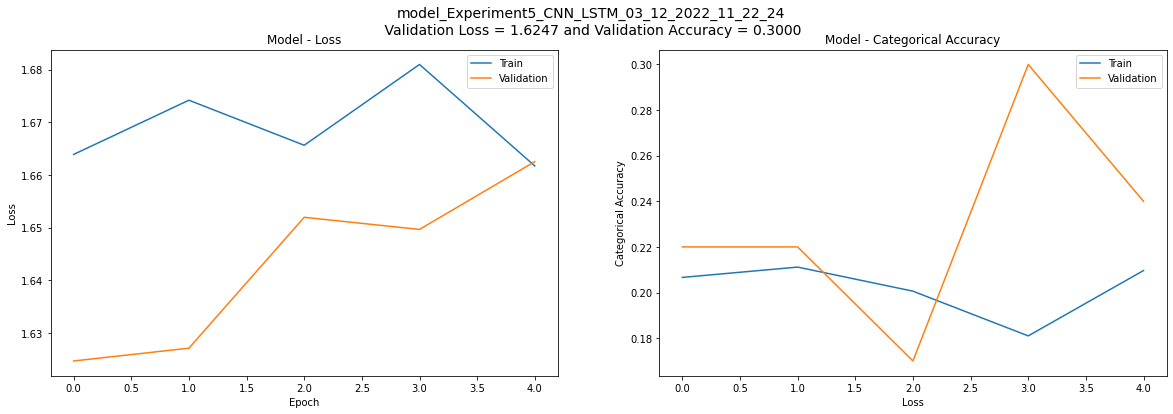

time: 8min 38s (started: 2022-12-03 11:22:24 +00:00)


In [23]:
# Exeperiment 5 - CNN LSTM
experiment5_cnn_lstm = Experiment5CNNLSTM()

# Initialize the path where project data resides
experiment5_cnn_lstm.initialize_path(project_dataset_path)

# Initialize the image properties
experiment5_cnn_lstm.initialize_image_properties(image_height=dim_x, 
                                                 image_width=dim_y)

# Initialize the batch size, frames to sample and the no. of epochs
experiment5_cnn_lstm.initialize_hyperparams(frames_to_sample=20, 
                                            batch_size=26,
                                            num_epochs=5)

# Define the model
experiment5_cnn_lstm.define_model()

# Print the model summary
experiment5_cnn_lstm.print_model_summary()

# Compile the model
experiment5_cnn_lstm.compile_model()

# Train and validation generator
experiment5_cnn_lstm.train_validation_generator(enable_augmentation=False)

# Initialize callbacks
experiment5_cnn_lstm.initialize_callbacks()

# Fit the model
experiment5_cnn_lstm.fit_model()

# Save model and history
experiment5_cnn_lstm.save_model_and_history()

# Plot model loss and accuracy
experiment5_cnn_lstm.plot_model_loss_and_accuracy()


### Experiment - 6

#### CNN - LSTM with GRU Model

* `lstm_cells` = 128
* `dense_neurons` = 256
* `dropout` = 0.3
* `frames_to_sample` = 20 
* `batch_size` = 13
* `num_epochs` = 50
* `enable_augmentation` = False

In [24]:
class Experiment6CNNLSTMGRU(BaseModel):
    def define_model(self):
        lstm_cells = 128
        dense_neurons = 256
        dropout = 0.5

        self.exp_name = "Experiment6_CNN_LSTM_GRU"
        date_time = datetime.now().strftime("%d_%m_%Y_%H_%M_%S")
        self.model_name = f"model_{self.exp_name}_{date_time}"

        self.model = Sequential()

        self.model.add(TimeDistributed(Conv2D(16, (3, 3), activation='relu'),
                                       input_shape=(self.frames_to_sample,
                                                    self.image_height,
                                                    self.image_width,
                                                    self.channels)))
        self.model.add(TimeDistributed(BatchNormalization()))
        self.model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        self.model.add(TimeDistributed(Conv2D(32, (3, 3), padding="same", activation='relu')))
        self.model.add(TimeDistributed(BatchNormalization()))
        self.model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        self.model.add(TimeDistributed(Conv2D(64, (3, 3), padding="same", activation='relu')))
        self.model.add(TimeDistributed(BatchNormalization()))
        self.model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        self.model.add(TimeDistributed(Conv2D(128, (3, 3), padding="same", activation='relu')))
        self.model.add(TimeDistributed(BatchNormalization()))
        self.model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        self.model.add(TimeDistributed(Flatten()))

        self.model.add(GRU(lstm_cells))
        self.model.add(Dropout(dropout))
        
        self.model.add(Dense(dense_neurons,activation='relu'))
        self.model.add(Dropout(dropout))
        
        self.model.add(Dense(self.num_classes, activation='softmax'))
        

time: 3.23 ms (started: 2022-12-03 11:31:03 +00:00)


Training Path => /content/Project_data/train
Number of Training Sequence = 663
Validation Path => /content/Project_data/val
Number of Validation Sequence = 100
Height = 120; Width = 120; Channels = 3
Number of Classes = 5; Total Franes = 30
Frames to Sample = 20; Batch Size = 13; Number of Epochs = 50
Model Name: model_Experiment6_CNN_LSTM_GRU_03_12_2022_11_31_03
Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_16 (TimeDi  (None, 20, 118, 118, 16)  448      
 stributed)                                                      
                                                                 
 time_distributed_17 (TimeDi  (None, 20, 118, 118, 16)  64       
 stributed)                                                      
                                                                 
 time_distributed_18 (TimeDi  (None, 20, 59, 59, 16)   0         
 stributed)       

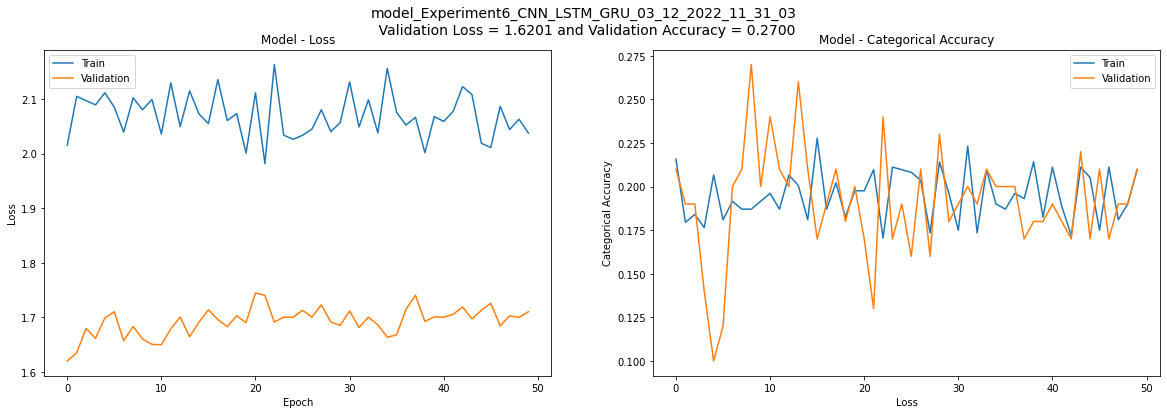

time: 1h 22min 54s (started: 2022-12-03 11:31:03 +00:00)


In [25]:
# Exeperiment 6 - CNN LSTM with GRU
experiment6_cnn_lstm_gru = Experiment6CNNLSTMGRU()

# Initialize the path where project data resides
experiment6_cnn_lstm_gru.initialize_path(project_dataset_path)

# Initialize the image properties
experiment6_cnn_lstm_gru.initialize_image_properties(image_height=dim_x, 
                                                     image_width=dim_y)

# Initialize the batch size, frames to sample and the no. of epochs
experiment6_cnn_lstm_gru.initialize_hyperparams(frames_to_sample=20, 
                                                batch_size=13,
                                                num_epochs=50)

# Define the model
experiment6_cnn_lstm_gru.define_model()

# Print the model summary
experiment6_cnn_lstm_gru.print_model_summary()

# Compile the model
experiment6_cnn_lstm_gru.compile_model()

# Train and validation generator
experiment6_cnn_lstm_gru.train_validation_generator(enable_augmentation=False)

# Initialize callbacks
experiment6_cnn_lstm_gru.initialize_callbacks()

# Fit the model
experiment6_cnn_lstm_gru.fit_model()

# Save model and history
experiment6_cnn_lstm_gru.save_model_and_history()

# Plot model loss and accuracy
experiment6_cnn_lstm_gru.plot_model_loss_and_accuracy()


### Experiment - 7

#### Transfer Learning with MobileNet and LSTM


* `lstm_cells` = 128
* `dense_neurons` = 128
* `dropout` = 0.5
* `frames_to_sample` = 20 
* `batch_size` = 17
* `num_epochs` = 30
* `enable_augmentation` = False

In [26]:
from keras.applications.mobilenet import MobileNet

class Experiment7MobileNetLSTM(BaseModel):
    def define_model(self):
        lstm_cells = 128
        dense_neurons = 128
        dropout = 0.5

        base_model_mobilenet = MobileNet(input_shape=(self.image_height,
                                                      self.image_width,
                                                      self.channels), 
                                         weights='imagenet',
                                         include_top=False)

        self.exp_name = "Experiment7_MobileNet_LSTM"
        date_time = datetime.now().strftime("%d_%m_%Y_%H_%M_%S")
        self.model_name = f"model_{self.exp_name}_{date_time}"

        self.model = Sequential()

        self.model.add(TimeDistributed(base_model_mobilenet,
                                       input_shape=(self.frames_to_sample,
                                                    self.image_height,
                                                    self.image_width,
                                                    self.channels)))
        
        for layer in self.model.layers:
            layer.trainable = False
        
        self.model.add(TimeDistributed(BatchNormalization()))
        self.model.add(TimeDistributed(MaxPooling2D((2, 2))))
        self.model.add(TimeDistributed(Flatten()))

        self.model.add(LSTM(lstm_cells))
        self.model.add(Dropout(dropout))
        
        self.model.add(Dense(dense_neurons,activation='relu'))
        self.model.add(Dropout(dropout))
        
        self.model.add(Dense(self.num_classes, activation='softmax'))


time: 10.3 ms (started: 2022-12-03 12:53:58 +00:00)


Training Path => /content/Project_data/train
Number of Training Sequence = 663
Validation Path => /content/Project_data/val
Number of Validation Sequence = 100
Height = 120; Width = 120; Channels = 3
Number of Classes = 5; Total Franes = 30
Frames to Sample = 20; Batch Size = 17; Number of Epochs = 30
17225924/17225924 [==============================] - 2s 0us/step
Model Name: model_Experiment7_MobileNet_LSTM_03_12_2022_12_54_00
Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_29 (TimeDi  (None, 20, 3, 3, 1024)   3228864   
 stributed)                                                      
                                                                 
 time_distributed_30 (TimeDi  (None, 20, 3, 3, 1024)   4096      
 stributed)                                                      
                                                                 
 time_distributed

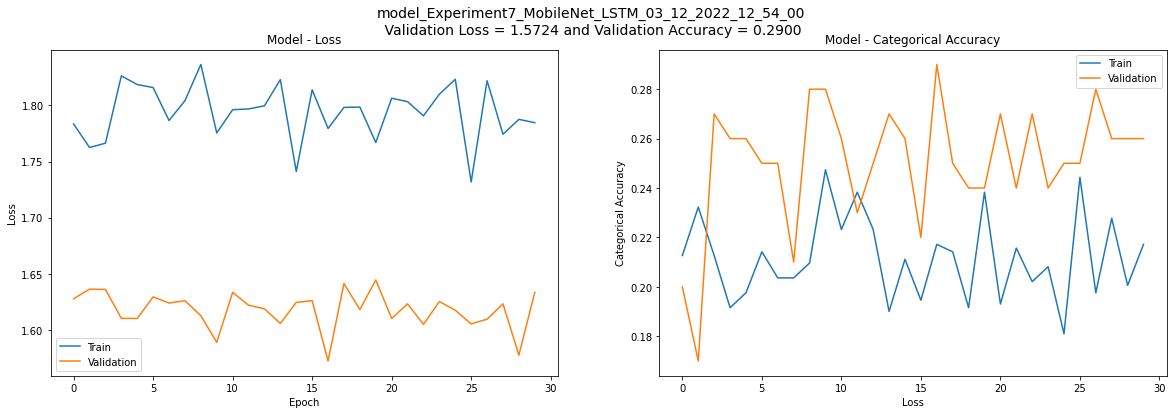

time: 49min 53s (started: 2022-12-03 12:53:58 +00:00)


In [27]:
# Exeperiment 7 - MobileNet and LSTM
experiment7_mobilenet_lstm = Experiment7MobileNetLSTM()

# Initialize the path where project data resides
experiment7_mobilenet_lstm.initialize_path(project_dataset_path)

# Initialize the image properties
experiment7_mobilenet_lstm.initialize_image_properties(image_height=dim_x, 
                                                      image_width=dim_y)

# Initialize the batch size, frames to sample and the no. of epochs
experiment7_mobilenet_lstm.initialize_hyperparams(frames_to_sample=20, 
                                                 batch_size=17,
                                                 num_epochs=30)

# Define the model
experiment7_mobilenet_lstm.define_model()

# Print the model summary
experiment7_mobilenet_lstm.print_model_summary()

# Compile the model
experiment7_mobilenet_lstm.compile_model()

# Train and validation generator
experiment7_mobilenet_lstm.train_validation_generator(enable_augmentation=False)

# Initialize callbacks
experiment7_mobilenet_lstm.initialize_callbacks()

# Fit the model
experiment7_mobilenet_lstm.fit_model()

# Save model and history
experiment7_mobilenet_lstm.save_model_and_history()

# Plot model loss and accuracy
experiment7_mobilenet_lstm.plot_model_loss_and_accuracy()


### Experiment - 8

#### Transfer Learning with MobileNet and GRU and training all weights


* `gru_cells` = 128
* `dense_neurons` = 256
* `dropout` = 0.5
* `frames_to_sample` = 20 
* `batch_size` = 13
* `num_epochs` = 50
* `enable_augmentation` = False

In [28]:
class Experiment8MobileNetGRU(BaseModel):
    def define_model(self):
        gru_cells = 128
        dense_neurons = 256
        dropout = 0.5

        base_model_mobilenet = MobileNet(weights='imagenet',
                                         include_top=False)

        self.exp_name = "Experiment8_MobileNet_GRU"
        date_time = datetime.now().strftime("%d_%m_%Y_%H_%M_%S")
        self.model_name = f"model_{self.exp_name}_{date_time}"

        self.model = Sequential()
        self.model.add(TimeDistributed(base_model_mobilenet,
                                       input_shape=(self.frames_to_sample,
                                                    self.image_height,
                                                    self.image_width,
                                                    self.channels)))
        
        self.model.add(TimeDistributed(BatchNormalization()))
        self.model.add(TimeDistributed(MaxPooling2D((2, 2))))
        self.model.add(TimeDistributed(Flatten()))
 
        self.model.add(GRU(gru_cells))
        self.model.add(Dropout(dropout))
        
        self.model.add(Dense(dense_neurons,activation='relu'))
        self.model.add(Dropout(dropout))
        
        self.model.add(Dense(self.num_classes, activation='softmax'))


time: 3.01 ms (started: 2022-12-03 13:43:51 +00:00)


Training Path => /content/Project_data/train
Number of Training Sequence = 663
Validation Path => /content/Project_data/val
Number of Validation Sequence = 100
Height = 120; Width = 120; Channels = 3
Number of Classes = 5; Total Franes = 30
Frames to Sample = 20; Batch Size = 13; Number of Epochs = 50
Model Name: model_Experiment8_MobileNet_GRU_03_12_2022_13_43_52
Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_33 (TimeDi  (None, 20, 3, 3, 1024)   3228864   
 stributed)                                                      
                                                                 
 time_distributed_34 (TimeDi  (None, 20, 3, 3, 1024)   4096      
 stributed)                                                      
                                                                 
 time_distributed_35 (TimeDi  (None, 20, 1, 1, 1024)   0         
 stributed)      

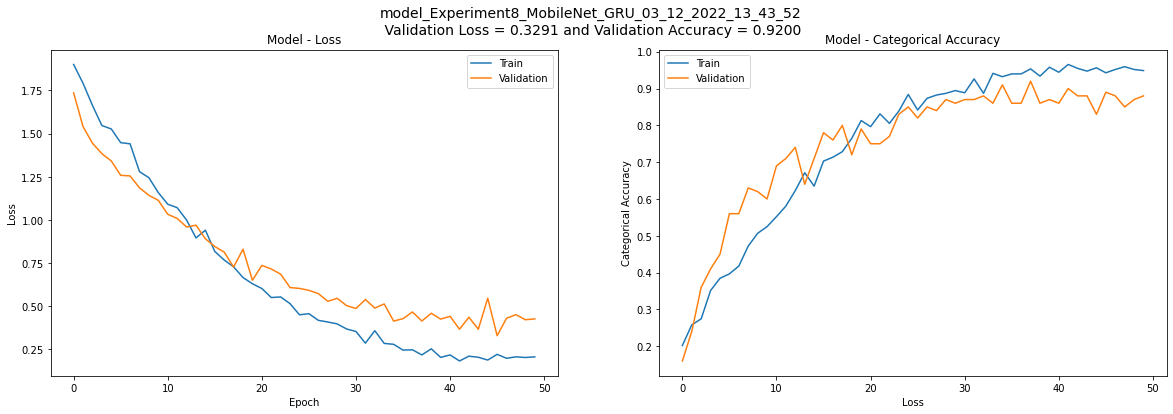

time: 1h 23min 12s (started: 2022-12-03 13:43:51 +00:00)


In [29]:
# Exeperiment 8 - ImageNet and LSTM with GRU
experiment8_mobilenet_lstm_gru = Experiment8MobileNetGRU()

# Initialize the path where project data resides
experiment8_mobilenet_lstm_gru.initialize_path(project_dataset_path)

# Initialize the image properties
experiment8_mobilenet_lstm_gru.initialize_image_properties(image_height=dim_x, 
                                                           image_width=dim_y)

# Initialize the batch size, frames to sample and the no. of epochs
experiment8_mobilenet_lstm_gru.initialize_hyperparams(frames_to_sample=20, 
                                                      batch_size=13,
                                                      num_epochs=50)

# Define the model
experiment8_mobilenet_lstm_gru.define_model()

# Print the model summary
experiment8_mobilenet_lstm_gru.print_model_summary()

# Compile the model
experiment8_mobilenet_lstm_gru.compile_model(optimiser=SGD(learning_rate=0.001))

# Train and validation generator
experiment8_mobilenet_lstm_gru.train_validation_generator(enable_augmentation=False)

# Initialize callbacks
experiment8_mobilenet_lstm_gru.initialize_callbacks()

# Fit the model
experiment8_mobilenet_lstm_gru.fit_model()

# Save model and history
experiment8_mobilenet_lstm_gru.save_model_and_history()

# Plot model loss and accuracy
experiment8_mobilenet_lstm_gru.plot_model_loss_and_accuracy()


### Experiment - 9

#### Transfer Learning with ResNet50 with GRU and training all weights


* `gru_cells` = 128
* `dense_neurons` = 256
* `dropout` = 0.5
* `frames_to_sample` = 20 
* `batch_size` = 13
* `num_epochs` = 50
* `enable_augmentation` = False

In [30]:
from tensorflow.keras.applications import ResNet50

class Experiment9ResNetGRU(BaseModel):
    def define_model(self):
        gru_cells = 64
        dense_neurons = 256
        dropout = 0.5

        base_model_resnet = Sequential([ResNet50(include_top=False, 
                                                 weights='imagenet', 
                                                 input_shape=(self.image_height, 
                                                              self.image_width, 
                                                              self.channels)), 
                                        Flatten()])

        self.exp_name = "Experiment9_ResNet_GRU"
        date_time = datetime.now().strftime("%d_%m_%Y_%H_%M_%S")
        self.model_name = f"model_{self.exp_name}_{date_time}"

        self.model = Sequential()
        self.model.add(TimeDistributed(base_model_resnet,
                                       input_shape=(self.frames_to_sample,
                                                    self.image_height,
                                                    self.image_width,
                                                    self.channels)))

        self.model.add(GRU(gru_cells, return_sequences=True))

        self.model.add(GRU(gru_cells))
        self.model.add(Dropout(dropout))
        
        self.model.add(Dense(dense_neurons,activation='relu'))
        self.model.add(Dropout(dropout))
        
        self.model.add(Dense(self.num_classes, activation='softmax'))


time: 46.6 ms (started: 2022-12-03 15:07:04 +00:00)


Training Path => /content/Project_data/train
Number of Training Sequence = 663
Validation Path => /content/Project_data/val
Number of Validation Sequence = 100
Height = 120; Width = 120; Channels = 3
Number of Classes = 5; Total Franes = 30
Frames to Sample = 20; Batch Size = 13; Number of Epochs = 50
94765736/94765736 [==============================] - 6s 0us/step
Model Name: model_Experiment9_ResNet_GRU_03_12_2022_15_07_13
Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_37 (TimeDi  (None, 20, 32768)        23587712  
 stributed)                                                      
                                                                 
 gru_2 (GRU)                 (None, 20, 64)            6304128   
                                                                 
 gru_3 (GRU)                 (None, 64)                24960     
                     

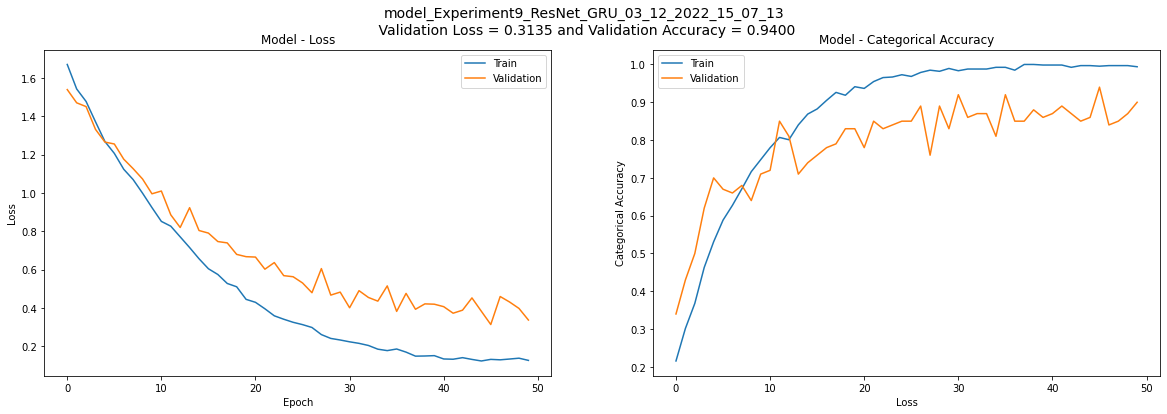

time: 1h 23min 16s (started: 2022-12-03 15:07:04 +00:00)


In [31]:
# Exeperiment 9 - ResNet with GRU
experiment9_resnet_gru = Experiment9ResNetGRU()

# Initialize the path where project data resides
experiment9_resnet_gru.initialize_path(project_dataset_path)

# Initialize the image properties
experiment9_resnet_gru.initialize_image_properties(image_height=dim_x, 
                                                           image_width=dim_y)

# Initialize the batch size, frames to sample and the no. of epochs
experiment9_resnet_gru.initialize_hyperparams(frames_to_sample=20, 
                                                      batch_size=13,
                                                      num_epochs=50)

# Define the model
experiment9_resnet_gru.define_model()

# Print the model summary
experiment9_resnet_gru.print_model_summary()

# Compile the model
experiment9_resnet_gru.compile_model(optimiser=SGD(learning_rate=0.001))

# Train and validation generator
experiment9_resnet_gru.train_validation_generator(normalize=False, 
                                                  enable_augmentation=False)

# Initialize callbacks
experiment9_resnet_gru.initialize_callbacks()

# Fit the model
experiment9_resnet_gru.fit_model()

# Save model and history
experiment9_resnet_gru.save_model_and_history()

# Plot model loss and accuracy
experiment9_resnet_gru.plot_model_loss_and_accuracy()
